In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
L = 40
a_absorb = 1.66
N = 267
v0_ratio_ = np.linspace(0, 3.5, 10)
v0_ratio = np.repeat(v0_ratio_, 10)
vp = np.array([10.0,25.0])
dt = 0.001
T = 10
pred_pos = np.array([0.0,0.0])
D0 = 1
tau_r = (1.10688**2)/(3*D0)
Q = np.array([[382116.03486762, 382574.47616531],
       [382572.22721697, 382138.61534273]])
wp = 13.3

# States -- Rows

### 0 - cross_prod is positive ---> predator is at left to particle
### 1 - cross_prod is negative ---> predator is at right to particle


# Actions -- Columns

### 0 - (+w0)
### 1 - (-w0)


# Q = np.array([[382116.03486762, 382574.47616531],
# --------->       [382572.22721697, 382138.61534273]])

In [3]:
def pos_valid(pos):
    
    r = np.linalg.norm((pred_pos - prey_pos + L/2)%L - L/2, axis=1)

    close_indices = np.where(r < a_absorb)[0]

    n_reset = len(close_indices)
        
    while n_reset > 0:
            
        new_pos = (np.random.rand(n_reset, 2) - 0.5) * L

        pos[close_indices] = new_pos            
        r = np.linalg.norm((pred_pos - prey_pos + L/2)%L - L/2, axis=1)
            
        close_indices = np.where(r < a_absorb)[0]

        n_reset = len(close_indices)
    
    return pos

In [4]:
def update_predator(pred_pos, pred_phi, prey_pos, v, wp, dt):
    
    vecs_to_prey = prey_pos - pred_pos 
    dists = np.linalg.norm(vecs_to_prey, axis=1)
    nearest_idx = np.argmin(dists)
    vec = vecs_to_prey[nearest_idx]

    predator_dir = np.array([np.cos(pred_phi), np.sin(pred_phi)])

    cross = predator_dir[0]*vec[1] - predator_dir[1]*vec[0]
    w = wp if cross > 0 else -wp

    new_phi = pred_phi + w * dt
    direction = np.array([np.cos(new_phi), np.sin(new_phi)])
    new_pos = pred_pos + v * direction * dt
    new_pos = (new_pos + L/2)%L - L/2

    return new_pos, new_phi

In [5]:
def cross_sign_from_orientation_and_position(positions, phi):
    phi = phi.flatten()

    positions = -positions
    
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)

    x = positions[:, 0]
    y = positions[:, 1]

    cross = cos_phi * y - sin_phi * x

    return (cross <= 0).astype(int)


# 0 - left is predator
# 1 - right is predator

In [6]:
dict_vp_to_J = {'10.0':[] , '25.0':[] }

In [7]:
for velocity_pred in vp:
    
    v0_values = velocity_pred*v0_ratio
    
    '''
    Note we have N prey and 1 predator at each v0 - prey,v - predator ; we need to find the Current density J0 
        how to you find ?
            for T/dt times ; we shift the prey and predator by the following mechanism
                predator is moved toward the nearby prey 
                    Its speed = v
                    Its angular speed = wp = 13.3
                prey is moved acc. to Q Matrix value
                    Its speed is due to the gaussian + always active .
                    Its direction however is due to two condn:
                        if predator is at right : --> -wp
                        if predator is at left  : --> +wp
                            + gaussian change !
                IN THIS WAY UPDATE THE POSITIONS AND FIND HOW MANY PARTICLES FALL BETWEEN 1.66 units to PREDATOR.
                ADD IT TO J0.
                
    '''
    kk = 0
    
    for v0 in v0_values:
        kk += 1

        pred_pos = np.array([0.0,0.0])
        pred_phi = 0.0
        
        prey_pos = (np.random.rand(N,2) - 0.5) * N
        prey_phi = (np.random.rand(N) * 2 * np.pi)

        prey_pos = pos_valid(prey_pos)

        J0_ = 0
        
        for t in range(int(T/dt)):

            r_vec = (pred_pos - prey_pos + L/2)%L - L/2  
            
            cross_products = cross_sign_from_orientation_and_position(-r_vec , prey_phi)

            
            actions = np.where(cross_products > 0, +wp, -wp)    

            prey_phi += np.sqrt(2*dt/tau_r) * (np.random.randn(N)) + actions*dt
            
            direction_vectors = np.vstack((np.cos(prey_phi) , np.sin(prey_phi))).T
            
            v = direction_vectors * v0
            
            prey_pos += v*dt + np.sqrt(2*D0*dt)*np.random.randn(N,2)

            pred_pos , pred_phi = update_predator(pred_pos, pred_phi, prey_pos, velocity_pred, wp, dt)
            
            r = np.linalg.norm((pred_pos - prey_pos + L/2)%L - L/2, axis=1)

            close_indices = np.where(r < a_absorb)[0]

            n_reset = len(close_indices)

            J0_+=n_reset
            
            while n_reset > 0:
            
                new_pos = (np.random.rand(n_reset, 2) - 0.5) * L

                prey_pos[close_indices] = new_pos            
                r = np.linalg.norm((pred_pos - prey_pos + L/2)%L - L/2, axis=1)
            
                close_indices = np.where(r < a_absorb)[0]

                n_reset = len(close_indices)
             
            prey_pos = (prey_pos + L/2) % L - L/2
        
        if kk % 10 == 0:
            print(kk)

        J0_ /= T
        dict_vp_to_J[str(velocity_pred)].append(J0_)

10
20
30
40
50
60
70
80
90
100
10
20
30
40
50
60
70
80
90
100


In [8]:
dict_vp_to_J

{'10.0': [8.3,
  8.3,
  9.2,
  10.9,
  9.7,
  10.5,
  8.8,
  9.1,
  11.1,
  9.4,
  2.7,
  1.7,
  2.2,
  2.2,
  1.9,
  2.6,
  2.8,
  2.3,
  2.3,
  4.6,
  0.6,
  0.5,
  0.3,
  0.6,
  0.4,
  0.4,
  0.4,
  0.6,
  0.5,
  0.2,
  0.3,
  0.1,
  0.1,
  0.0,
  0.4,
  0.1,
  0.1,
  0.2,
  0.1,
  0.2,
  0.0,
  0.1,
  0.0,
  0.3,
  0.0,
  0.0,
  0.1,
  0.2,
  0.3,
  0.0,
  0.0,
  0.1,
  0.0,
  0.1,
  0.1,
  0.4,
  0.3,
  0.1,
  0.1,
  0.0,
  0.2,
  0.1,
  0.1,
  0.0,
  0.2,
  0.0,
  0.2,
  0.0,
  0.1,
  0.0,
  0.0,
  0.1,
  0.0,
  0.1,
  0.2,
  0.2,
  0.0,
  0.2,
  0.1,
  0.2,
  0.1,
  0.0,
  0.0,
  0.0,
  0.1,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1,
  0.1,
  0.1,
  0.1,
  0.2,
  0.3,
  0.1,
  0.4,
  0.3,
  0.1,
  0.2],
 '25.0': [20.3,
  16.6,
  21.8,
  21.2,
  21.9,
  24.1,
  24.0,
  23.1,
  21.4,
  17.4,
  10.5,
  6.3,
  7.5,
  7.7,
  5.3,
  9.7,
  7.4,
  8.7,
  7.8,
  7.4,
  0.5,
  0.7,
  0.6,
  0.5,
  0.4,
  0.5,
  0.2,
  0.3,
  0.8,
  0.7,
  0.0,
  0.3,
  0.1,
  0.0,
  0.2,
  0.0,
  0.1,
  0.1,
  0

In [9]:
ten = dict_vp_to_J['10.0']

In [10]:
twenty_five = dict_vp_to_J['25.0']

In [11]:
mean_J_10 = []
mean_J_25 = []

In [12]:
i = 0
for j in range(10):
    mean_J_10.append(sum(ten[i:i+10]) / 10)
    i += 10

In [13]:
i = 0
for j in range(10):
    mean_J_25.append(sum(twenty_five[i:i+10]) / 10)
    i += 10

In [14]:
J_10 = np.array(mean_J_10) / mean_J_10[0]

In [15]:
J_25 = np.array(mean_J_25) / mean_J_25[0]

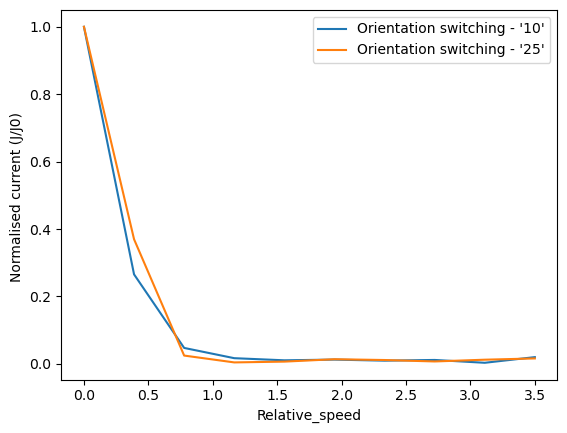

In [16]:
plt.plot(np.linspace(0,3.5,10) , J_10 , label = "Orientation switching - '10'")
plt.plot(np.linspace(0,3.5,10) , J_25 , label = "Orientation switching - '25'")
plt.xlabel('Relative_speed')
plt.ylabel('Normalised current (J/J0) ')
plt.legend();

In [17]:
J_10

array([1.        , 0.26547744, 0.04721931, 0.01678909, 0.01049318,
       0.01259182, 0.00944386, 0.0115425 , 0.00314795, 0.01993704])

In [18]:
J_25

array([1.        , 0.36968839, 0.02455146, 0.00424929, 0.00661001,
       0.01369216, 0.01133144, 0.00708215, 0.01227573, 0.01605288])